In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import random

from features import SupportVectorClassifier
from features import FeatureExtractor

def show_images(images, per_row=2, main_title=None):
    figure = plt.figure(1)

    for n, img in enumerate(images):
        ax = figure.add_subplot(np.ceil(len(images) / per_row), per_row, n + 1)

        ax.grid(False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        plt.axis("off")

        plt.imshow(img)
    if main_title is not None:
        plt.suptitle(main_title)

    plt.show()

# Exploring The Data Set

Vehicle Images:
   Count:       8792 of 17760 (49.50%)
   Value Range: 0 to 255
   Shape:       64 x 64


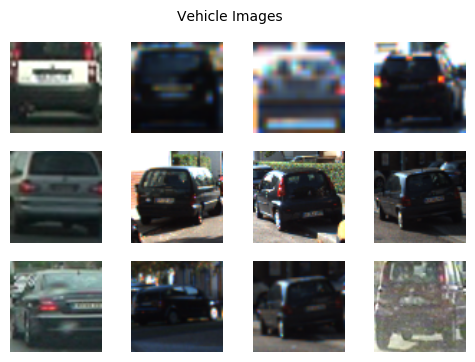



Non Vehicle Images:
   Count:       8968 of 17760 (50.50%)
   Value Range: 0 to 255
   Shape:       64 x 64


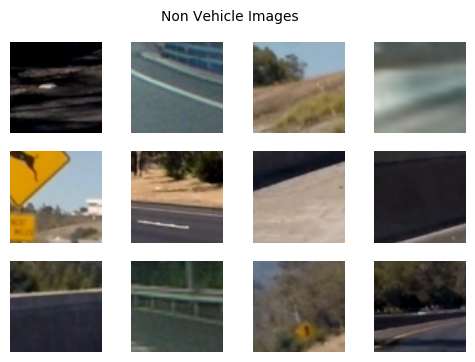

In [3]:
from features import DataLoader


def explore_data(title, data, total_count, image_sample_count=12):
    count = len(data)
    percentage_of_total = count * 100.0 / total_count
    shape = data[0].shape
    minmax_range = (np.amin(data), np.amax(data))
    
    print('{:s}:'.format(title))
    print('   Count:       {:d} of {:d} ({:3.2f}%)'.format(count, total_count, percentage_of_total))
    print('   Value Range: {} to {}'.format(minmax_range[0], minmax_range[1]))
    print('   Shape:       {} x {}'.format(shape[0], shape[1]))
    
    sample_images = []
    for i in range(0, image_sample_count):
        sample_images.append(random.choice(data))
        
    show_images(sample_images, per_row=4, main_title=title)
    
    return count, shape, minmax_range

# load vehicle and non vehicle data
loader = DataLoader()
vehicle_data = loader.load_data(path="vehicles/**/*.png")
non_vehicle_data = loader.load_data(path="non-vehicles/**/*.png")

# compute total number of features
image_count = len(vehicle_data) + len(non_vehicle_data)

# show details about each data set
result = explore_data("Vehicle Images", vehicle_data, image_count)
print("")
print("")
result = explore_data("Non Vehicle Images", non_vehicle_data, image_count)

# Evaluating Support Vector Color Classifier 

In [ ]:

featureExtractor = FeatureExtractor()

# color and binning parameters
bins = (16,32, 64)
sizes = ((32,32), (24,24), (16,16))
colorspaces = ('RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb')

# hog parameters
orientation_configs = (6, 9, 12)
pix_per_cells_configs = (4, 8, 12)
cells_per_block_configs = (1,2,3)

number_of_times_for_average = 1
results = {}
for bin_count in bins:
    for size in sizes:
        for colorspace in colorspaces:
            for orientation in orientation_configs:
                for pix_per_cell in pix_per_cells_configs:
                    for cells_per_block in cells_per_block_configs:
                        total_score = 0
                        for times in range(0,number_of_times_for_average):
                            vehicle_features = featureExtractor.extract_features(vehicle_data, 
                                                                                 colorspace=colorspace, 
                                                                                 spatial_size=size,
                                                                                 hist_bins=bin_count,
                                                                                 orientations=orientation,
                                                                                 pixels_per_cell=pix_per_cell,
                                                                                 cells_per_block=cells_per_block)

                            non_vehicle_features = featureExtractor.extract_features(non_vehicle_data, 
                                                                                 colorspace=colorspace, 
                                                                                 spatial_size=size,
                                                                                 hist_bins=bin_count,
                                                                                 orientations=orientation,
                                                                                 pixels_per_cell=pix_per_cell,
                                                                                 cells_per_block=cells_per_block)
                            print("vehicle_feature_size", vehicle_features.shape)
                            print("non-vehicle_feature_size", non_vehicle_features.shape)
#                             classifier = SupportVectorClassifier(vehicle_features, non_vehicle_features)
#                             total_score += classifier.train_and_score(test_size=0.2)

#                         args = "colspace: {}, size: {}, bins: {}, orientation: {}, pix/cell: {}, cells/block: {}".format(colorspace, size, bin_count, orientation, pix_per_cell, cells_per_block)        
#                         results[args] = total_score / number_of_times_for_average
#                         print("{:.5f}".format(total_score/number_of_times_for_average), "==>", args)

print("")
print("TOP 10 CONFIGURATIONS")
# show top 10 results and the arguments that produces them
for r in sorted(results, key=results.get, reverse=True)[:10]:
    print(r, results[r])

print("Done")

In [ ]:
from features import SupportVectorClassifier
from features import FeatureExtractor

colorspace = 'HSV'
size = (32,32)
bins = 16
orientation = 9
pix_per_cell = 4
cells_per_block = 1

orientation_configs = (6, 9, 12)
pix_per_cells_configs = (1, 2, 4, 8)
cells_per_block_configs = (1,2,3)

number_of_times_for_average = 1
results = {}
featureExtractor = FeatureExtractor()
total_score = 0
for orientation in orientation_configs:
    for pix_per_cell in pix_per_cells_configs:
        for cells_per_block in cells_per_block_configs:
            for times in range(0,number_of_times_for_average):
                vehicle_features = featureExtractor.extract_features(vehicle_data, 
                                                                     colorspace=colorspace, 
                                                                     spatial_size=size,
                                                                     hist_bins=bins,
                                                                     orientations=orientation,
                                                                     hog_pixels_per_cell=pix_per_cell,
                                                                     hog_cells_per_block=cells_per_block)

                non_vehicle_features = featureExtractor.extract_features(non_vehicle_data, 
                                                                     colorspace=colorspace, 
                                                                     spatial_size=size,
                                                                     hist_bins=bins,
                                                                     orientations=orientation,
                                                                     hog_pixels_per_cell=pix_per_cell,
                                                                     hog_cells_per_block=cells_per_block)
                
                print("vehicle features:",vehicle_features.shape)
                print("non vehicle features:",non_vehicle_features.shape)
#                 classifier = SupportVectorClassifier(vehicle_features, non_vehicle_features)
#                 total_score += classifier.train_and_score(test_size=0.2)

#             args = "colspace: {}, size: {}, bins: {}, orientation: {}, pix/cell: {}, cells/block: {}".format(colorspace, size, bins, orientation, pix_per_cell, cells_per_block)        
#             results[args] = total_score / number_of_times_for_average
#             print("{:.5f}".format(total_score/number_of_times_for_average), "==>", args)

In [ ]:
classifier = SupportVectorClassifier(vehicle_features, non_vehicle_features)
score = classifier.train_and_score(test_size=0.2)
print(score)

In [ ]:
import cv2
def get_frames(video_file, output_dir):
    vidcap = cv2.VideoCapture(video_file)
    success,image = vidcap.read()
    count = 0
    good_to_go = True
    while success:
        good_to_go,image = vidcap.read()
        if count % 15 == 0:
            cv2.imwrite(output_dir +"frame%d.jpg" % count, image)     # save frame as JPEG file
        count += 1
get_frames(video_file='project_video.mp4', output_dir='project_video_images/')

# Sliding Windows

In [ ]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list
    
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    count = 0

    # Iterate through the bounding boxes
    for bbox in bboxes:
        color = (random.randint(0,255), random.randint(0,255), random.randint(0,255))
        if count % 5 != 1:
            # Draw a rectangle given bbox coordinates
            cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        count += 1
    # Return the image copy with boxes drawn
    return imcopy

img = cv2.imread('project_video_images/frame240.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

windows = []
# windows = my_slider(img, x_start_stop=[0, 1280], center_y_start_stop=(550, 400), 
#                     starting_window_size=(280, 280), xy_shift_amount=(.33, .10))

windows = slide_window(img, x_start_stop=[50, None], y_start_stop=[375, 500], 
                    xy_window=(64, 64), xy_overlap=(0.4, 0.4))

windows = slide_window(img, x_start_stop=[50, None], y_start_stop=[300, 600], 
                    xy_window=(150, 150), xy_overlap=(0.65, 0.65))
# windows = slide_window(img, x_start_stop=[20, None], y_start_stop=[300, 700], 
#                     xy_window=(225, 225), xy_overlap=(0.7, 0.75))
# windows += slide_window(img, x_start_stop=[None, None], y_start_stop=[300, 900], 
#                     xy_window=(300, 300), xy_overlap=(0.75, 0.75))
print(len(windows))

img = draw_boxes(img, windows)

plt.imshow(img)
plt.show()

In [ ]:
from features import ImageSampler

img = cv2.imread('project_video_images/frame240.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

sampler = ImageSampler(img_shape=img.shape)
samples = sampler.sample_image(img)
print(len(samples))
random_samples = []

for i in range(0,20):
    random_samples.append(random.choice(samples))

show_images(images=random_samples, per_row=5)

In [11]:
import time


1488053403.649804
1488053403.654736
